# Stock Prediction Using Neural Networks
### Thomas Billington

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

### Stock Preperation and Visualization

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<Figure size 1080x504 with 0 Axes>

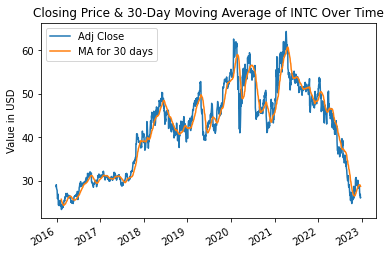

<Figure size 1080x504 with 0 Axes>

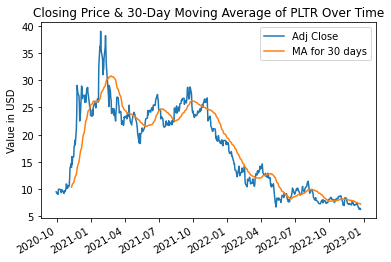

<Figure size 1080x504 with 0 Axes>

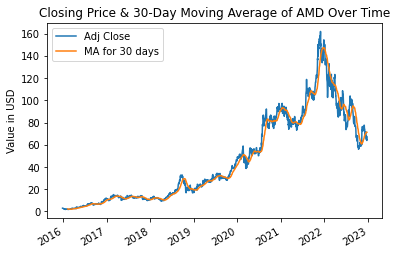

<Figure size 1080x504 with 0 Axes>

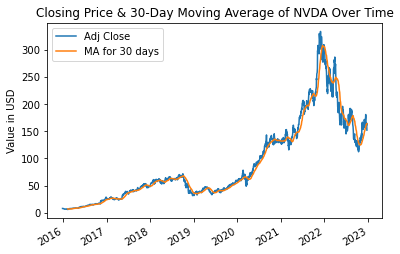

<Figure size 1080x504 with 0 Axes>

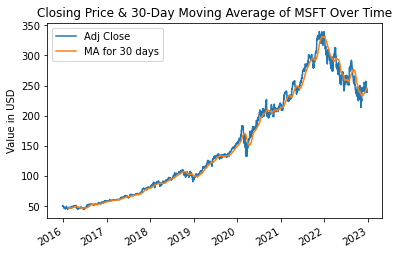

In [11]:
companylist = ['INTC', 'PLTR', 'AMD', 'NVDA', "MSFT"]
companynames = ['INTC', 'PLTR', 'AMD', 'NVDA', "MSFT"]

#sets an end date of todays date along with a start date of 2 years prior
enddate = datetime.now()
startdate = datetime(enddate.year - 7, enddate.month, enddate.day)

#goes through each company in the list and loads the data accordingly
counter = 0
for stock in companylist:
    companylist[counter] = yf.download(stock, startdate, enddate)
    counter += 1

#creates a dataframe with the company name and the listing data
for company, companyname in zip(companylist, companynames):
    company["Listing"] = companyname

df = pd.concat(companylist, axis=0)

#df.tail(10)
#companylist[3].describe()

#visualizing the closing price as well as the 30 day moving average of each listing
for company in companylist:
        column_name = f"MA for 30 days"
        company[column_name] = company['Adj Close'].rolling(30).mean()

counter2 = 0
for i, company in enumerate(companylist, 1):
    plt.figure(figsize=(15, 7))
    company[['Adj Close', 'MA for 30 days']].plot()
    plt.ylabel('Value in USD')
    plt.xlabel(None)
    plt.title(f"Closing Price & 30-Day Moving Average of {companynames[counter2]} Over Time")
    counter2 += 1

### Data Formatting

In [12]:
data = yf.download('NVDA', startdate, enddate)
data.drop(['Volume', 'Close'], axis=1, inplace=True)
#Creates columns for next target close as well as taget difference
data['Target_Diff'] = data['Adj Close'] - data.Open
data['Target_Diff'] = data['Target_Diff'].shift(-1)
data['Next_Close'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
df = data.values

scalar = MinMaxScaler(feature_range=(0,1))
df_scaled = scalar.fit_transform(df)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Adj Close,Target_Diff,Next_Close
Date,,,,,,
2015-12-28,8.205000,8.285000,8.090000,8.091793,-0.066355,8.223645
2015-12-29,8.290000,8.445000,8.267500,8.223645,-0.259664,8.152837
2015-12-30,8.412500,8.485000,8.345000,8.152837,-0.287160,8.047840
2015-12-31,8.335000,8.372500,8.240000,8.047840,-0.168716,7.903784
2016-01-04,8.072500,8.145000,8.010000,7.903784,-0.214250,8.030750
...,...,...,...,...,...,...
2022-12-16,168.639999,170.410004,164.100006,165.710007,-3.180008,162.539993
2022-12-19,165.720001,166.089996,161.449997,162.539993,0.210007,160.850006
2022-12-20,160.639999,163.100006,158.520004,160.850006,3.869995,165.009995


In [13]:
data_x = []
#Uses increments of 14 days
days = 14
#takes only the first 5 columns of data as input for the LSTM
for i in range(5):
    data_x.append([])
    for j in range(days, df_scaled.shape[0]):
        data_x[i].append(df_scaled[j - days:j, i])

data_x = np.moveaxis(data_x, [0], [2])
data_x = np.array(data_x)

#Uses the last column, the next close value, as validation

data_ystart = np.array(df_scaled[days:, -1])
data_y = np.reshape(data_ystart, (len(data_ystart), 1))

#Training and testing split

X_train, X_test = data_x[:int(len(data_x)*0.8)], data_x[int(len(data_x)*0.8):]
y_train, y_test = data_y[:int(len(data_x)*0.8)], data_y[int(len(data_x)*0.8):]

In [14]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (days, 5)))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=15, epochs=30, shuffle = True, validation_split = 0.1)

Epoch 1/30
84/84 [==============================] - 15s 74ms/step - loss: 0.0026 - val_loss: 0.0073
Epoch 2/30
84/84 [==============================] - 5s 65ms/step - loss: 7.8289e-04 - val_loss: 0.0023
Epoch 3/30
84/84 [==============================] - 5s 64ms/step - loss: 7.5873e-04 - val_loss: 0.0014
Epoch 4/30
84/84 [==============================] - 5s 65ms/step - loss: 6.3240e-04 - val_loss: 0.0027
Epoch 5/30
84/84 [==============================] - 5s 65ms/step - loss: 7.3064e-04 - val_loss: 0.0036
Epoch 6/30
84/84 [==============================] - 6s 66ms/step - loss: 6.3230e-04 - val_loss: 0.0031
Epoch 7/30
84/84 [==============================] - 6s 67ms/step - loss: 6.2544e-04 - val_loss: 0.0011
Epoch 8/30
84/84 [==============================] - 6s 67ms/step - loss: 6.8826e-04 - val_loss: 0.0034
Epoch 9/30
84/84 [==============================] - 6s 68ms/step - loss: 5.3660e-04 - val_loss: 0.0013
Epoch 10/30
84/84 [==============================] - 6s 70ms/step - loss: 5.

In [15]:
pred = model.predict(X_test)
for i in range(14):
    print(pred[i], y_test[i])

[0.5572152] [0.60275428]
[0.56169766] [0.60058741]
[0.5663437] [0.58963063]
[0.57073057] [0.58239741]
[0.5737554] [0.58868465]
[0.5746058] [0.59732172]
[0.57400364] [0.59005792]
[0.5734526] [0.57504217]
[0.572918] [0.56228468]
[0.5716312] [0.58541887]
[0.56874675] [0.61648833]
[0.56552774] [0.65134222]
[0.5643743] [0.64630642]
[0.5681274] [0.65912489]


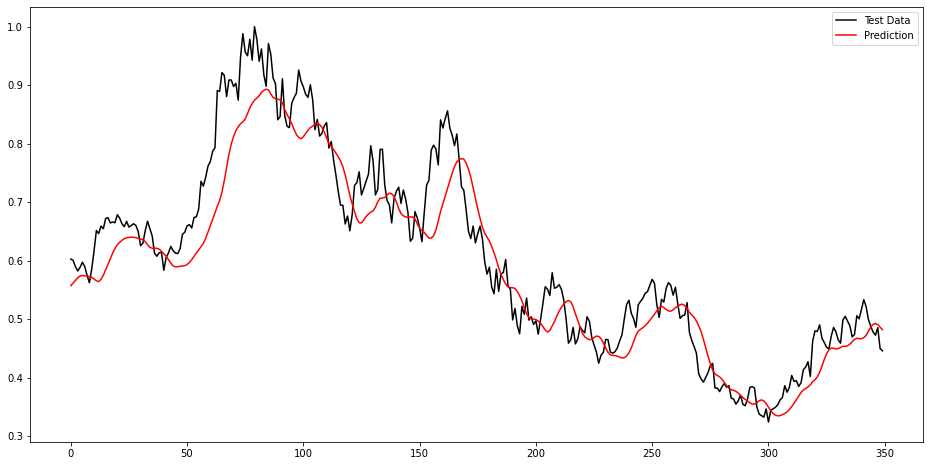

In [18]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test Data')
plt.plot(pred, color = 'red', label = 'Prediction')
plt.legend()
plt.show()